# Tutorial - Green Urban Scenarious
A demo of a minimal flow of GUS process.

For more advanced use cases, please see upcoming article. For more structured experiment and scenario analyis plese see model sepcification and code documentation within the docs/ folder. 

In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 3
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json
import pprint
pp = pprint.PrettyPrinter(indent=1)
sns.set_theme()

## 0. Importing GUS modules

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.gus.models import Urban
from src.gus.utilities import get_raster_data

## 1. Initilisation

### 1.1 Importing data on site, tree populations, experiment parameters

In [3]:
import logging
logfile = os.path.join(module_path, 'outputs/gus.log')
logging.basicConfig(filename=logfile, format='%(asctime)s %(levelname)s %(message)s', level=logging.INFO)

# File that holds site/city other geolocated data and parameters
fname_config_site = os.path.join(module_path, 'inputs/site.json')

# File that include tree species specific parameters
fname_config_allometrics = os.path.join(module_path, 'inputs/allometrics.json')

# File that include individual tree data including their location on a 2D raster of the actual location
fname_data_trees = os.path.join(module_path, 'inputs/trees.csv')

# File that holds experiment parameters
fname_scenario_params = os.path.join(module_path, 'inputs/scenario.json')

In [4]:
f = open(fname_config_allometrics)
config_allometrics = json.loads(f.read())
#pp.pprint(config_allometrics)

In [5]:
f = open(fname_config_site)
config_site = json.loads(f.read())
pp.pprint(config_site)

{'area_impervious_in_m2': 500,
 'area_pervious_in_m2': 500,
 'area_total_in_m2': 1000,
 'area_tree_density_per_hectare': 400,
 'project_site_type': 'park',
 'weather': {'growth_season_mean': 200, 'growth_season_var': 7}}


In [6]:
df_pop = pd.read_csv(fname_data_trees)
df_pop.tail()

,id,species,dbh,height,condition,xpos,ypos
95,96,conifer,13.871098,3.303454,good,17,4
96,97,conifer,12.561324,3.165903,good,17,5
97,98,conifer,13.651542,3.436859,good,17,6
98,99,conifer,12.610441,3.195499,good,17,3
99,100,conifer,12.491068,3.467151,excellent,17,7


In [7]:
f = open(fname_scenario_params)
scenario_params = json.loads(f.read())
pp.pprint(scenario_params)

{'is_crownsunexposure_fixed': 1,
 'maintenance_scope': 2,
 'time_horizon_years': 50}


### 1.2 Creating a digital twin of the site

In [8]:
site = Urban(df_pop,
            fname_config_allometrics,
            fname_config_site,
            scenario_params)

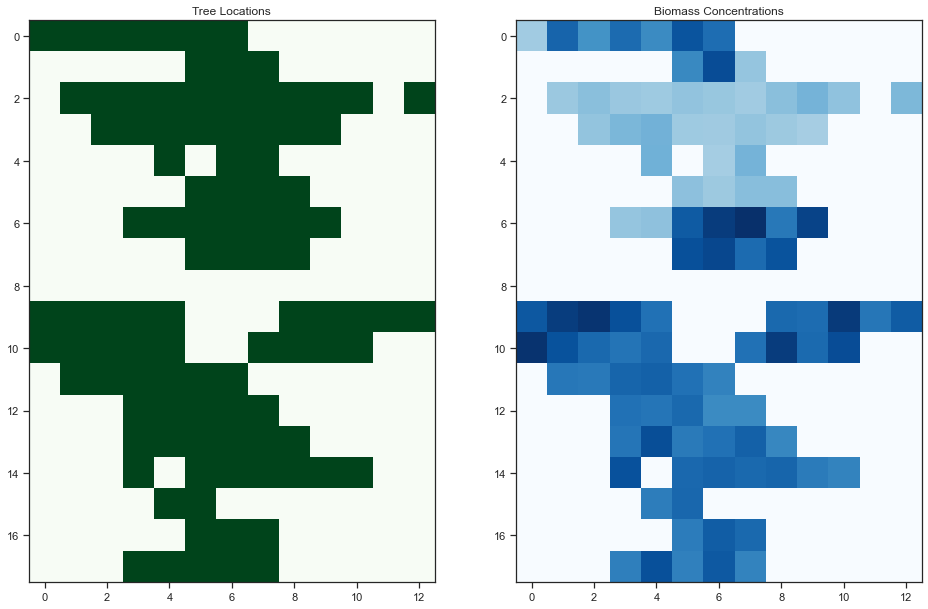

In [9]:
initial_locations = get_raster_data(site, counts=True)
initial_biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,12))
plt.subplot(121)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Tree Locations")
plt.subplot(122)
plt.title("Biomass Concentrations")
plt.imshow(initial_biomass, cmap='Blues')
#plt.colorbar(label = 'Biomass - Kg')
plt.show()

## 2. Running the scenario

In [10]:
for i in range(scenario_params['time_horizon_years']):
    site.step()

## 3. Analysis

### 3.1 Individual tree level inspections 

In [11]:
# Tree level individual variables
fname_output_trees = os.path.join(module_path, 'outputs/trees_yearly.json')
df_out_tree = site.datacollector.get_agent_vars_dataframe()
df_out_tree.to_csv(fname_output_trees, index=True)
df_out_tree.tail()

species        dbh    height    crownH    crownW  \
Step AgentID                                                     
50   166       decidu  12.217574  9.702765  5.076427  4.396149   
     167      conifer  12.013465  7.451424  4.542400  2.890564   
     168      conifer   9.897037  6.275630  3.992045  2.499102   
     169      conifer   9.527148  6.065843  3.893964  2.429726   
     170      conifer   9.417743  6.003548  3.864846  2.409152   

              canopy_overlap       cle  condition   dieback    biomass  \
Step AgentID                                                             
50   166            0.612030  0.692059       good  0.020917  66.112005   
     167            0.074917  0.958073  excellent  0.003004  54.969261   
     168            0.069438  0.959089  excellent  0.003535  34.218181   
     169            0.000000  0.560000  excellent  0.000634  31.174140   
     170            0.000000  0.560000  excellent  0.003765  30.305758   

                   seq     carbon  deroot  detrunk   mulched  burnt  \
Step AgentID                                                          
50   166      5.860594  33.056002     0.0      0.0  0.034571    0.0   
     167      4.087258  27.484631     0.0      0.0  0.004129    0.0   
     168      3.058718  17.109090     0.0      0.0  0.003024    0.0   
     169      0.000000  15.587070     0.0      0.0  0.000000    0.0   
     170      0.000000  15.152879     0.0      0.0  0.000000    0.0   

             coordinates  
Step AgentID              
50   166          (5, 6)  
     167         (12, 6)  
     168         (13, 6)  
     169         (15, 5)  
     170          (0, 3)

In [12]:
Specific_Tree = df_out_tree.xs(42, level="AgentID")
Specific_Tree.tail()

,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,dieback,biomass,seq,carbon,deroot,detrunk,mulched,burnt,coordinates
Step,,,,,,,,,,,,,,,,,
46,decidu,50.642609,21.005761,11.825519,10.813584,0.536315,0.798838,excellent,0.007,1621.291715,11.751118,810.645857,0.0,0.0,0.283726,0.0,"(6, 8)"
47,decidu,50.987411,21.083328,11.855261,10.849445,0.539039,0.797537,excellent,0.006,1646.236793,12.472539,823.118396,0.0,0.0,0.246936,0.0,"(6, 8)"
48,decidu,51.301287,21.153730,11.881859,10.881753,0.540787,0.796828,excellent,0.007,1669.128679,11.445943,834.564340,0.0,0.0,0.292098,0.0,"(6, 8)"
49,decidu,51.618989,21.224790,11.908319,10.914129,0.541023,0.796995,excellent,0.006,1692.478624,11.674973,846.239312,0.0,0.0,0.253872,0.0,"(6, 8)"
50,decidu,51.915891,21.291018,11.932625,10.944088,0.542022,0.796705,excellent,0.005,1714.462844,10.992110,857.231422,0.0,0.0,0.214308,0.0,"(6, 8)"


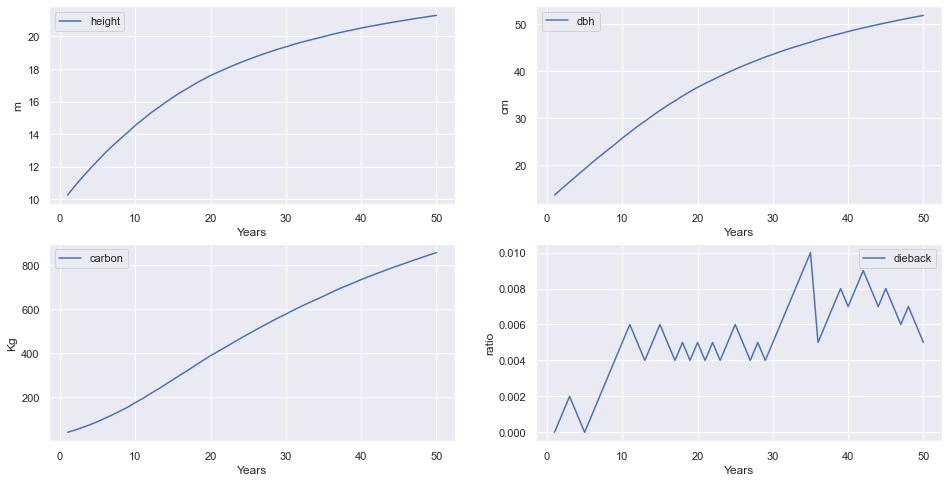

In [13]:
sns.set_theme()
fig = plt.figure(figsize=(16,8))
plt.subplot(221)
Specific_Tree.height.plot()
plt.xlabel('Years')
plt.ylabel('m')
plt.legend()
plt.subplot(222)
Specific_Tree.dbh.plot()
plt.xlabel('Years')
plt.ylabel('cm')
plt.legend()
plt.subplot(223)
Specific_Tree.carbon.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.subplot(224)
Specific_Tree.dieback.plot()
plt.xlabel('Years')
plt.ylabel('ratio')
plt.legend()
plt.show()

### 3.2 Site level inspections

In [14]:
# Site level aggregate variables
df_out_site = site.datacollector.get_model_vars_dataframe()
df_out_site.tail()

,Storage,Seq,Released,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std
45,71328.674000,1519.920657,967.346474,96,4,0,0,0,63,9.559706
46,73070.343149,1679.177517,421.116150,100,0,0,0,0,67,10.496103
47,74657.053704,1586.710555,464.033925,99,1,0,0,0,67,9.899931
48,76316.283130,1645.179054,524.970396,98,2,0,0,0,68,10.502891
49,77916.569380,1569.546301,1189.134306,98,2,0,0,0,70,10.199940


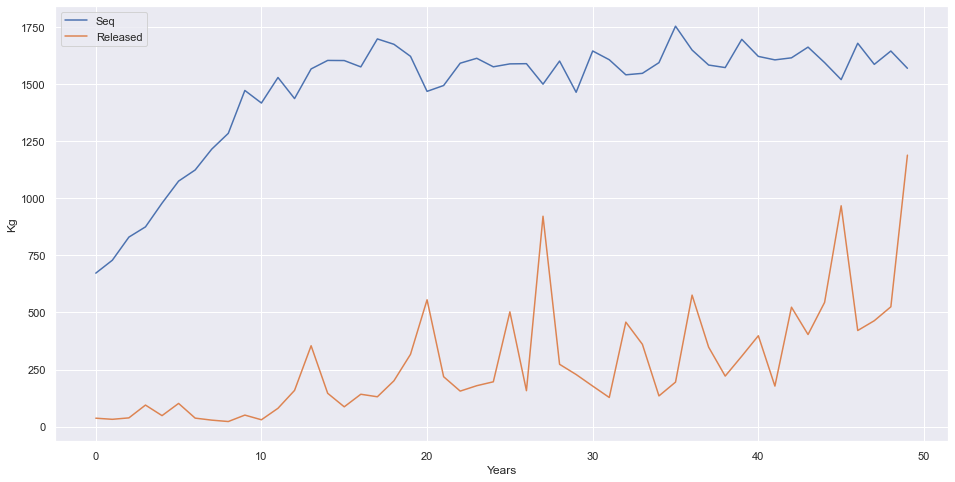

In [15]:
fig = plt.figure(figsize=(16,8))
df_out_site.Seq.plot()
df_out_site.Released.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.show()

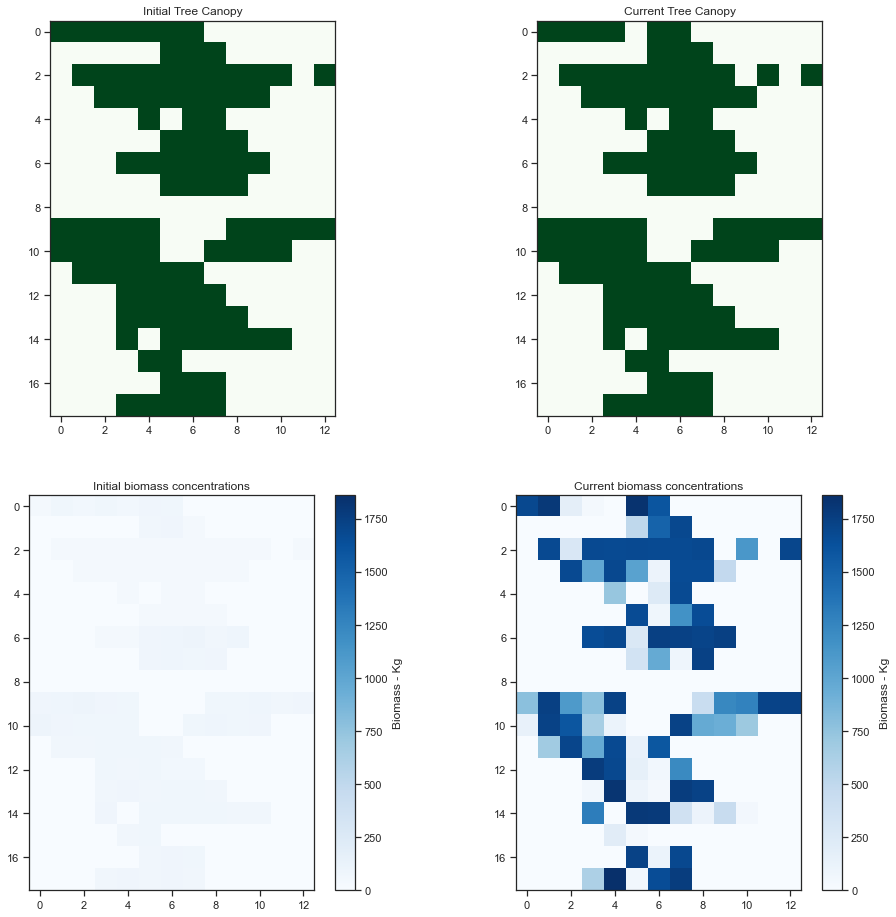

In [16]:
locations = get_raster_data(site, counts=True)
biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Initial Tree Canopy")

plt.subplot(222)
plt.imshow(locations, cmap='Greens')
plt.title("Current Tree Canopy")

plt.subplot(223)
plt.title("Initial biomass concentrations")
plt.imshow(initial_biomass, cmap='Blues', vmin=0, vmax=biomass.max())
plt.colorbar(label = 'Biomass - Kg')

plt.subplot(224)
plt.title("Current biomass concentrations")
plt.imshow(biomass, cmap='Blues')
plt.colorbar(label = 'Biomass - Kg')
plt.show()